## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization, Activation, Dropout, regularizers
"""
Code Here 建立你的神經網路
"""
def build_mlp(input_shape,output_units=10, num_neurons=[512, 256, 128],use_bn=True,drp_ratio=0,l2_ratio=0):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(input_layer)

            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)

        else:
            x = keras.layers.Dense(units=n_units, 
                                   kernel_regularizer=regularizers.l2(l2_ratio),
                                   name="hidden_layer"+str(i+1))(x)
            if use_bn:
                x = BatchNormalization()(x)
            x = Activation("relu")(x)
            x = Dropout(drp_ratio)(x)
            
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 0.001
EPOCHS = 20
BATCH_SIZE = 128

"""
建立實驗組合
"""
USE_BN = [True, False]
DRP_RATIO = [0.2, 0.4, 0.8]
L2_RATIO = [0.01, 0.0001, 0.0000001]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""

for i, (use_bn, drp_ratio, l2_ratio) in enumerate(itertools.product(USE_BN, DRP_RATIO, L2_RATIO)):
    keras.backend.clear_session()
    print("Numbers of exp: %i, with bn: %s, drp_ratio: %.2f, l2_ratio: %.2f" % (i, use_bn, drp_ratio, l2_ratio))
    model = build_mlp(input_shape=x_train.shape[1:], use_bn=use_bn, drp_ratio=drp_ratio, l2_ratio=l2_ratio)
    model.summary()
    optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              verbose=1,
              shuffle=True)
    
    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, with bn: True, drp_ratio: 0.20, l2_ratio: 0.01
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_____________________

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 104us/step - loss: 1.9254 - acc: 0.3700 - val_loss: 2.0828 - val_acc: 0.3010
Epoch 2/20
50000/50000 [==============================] - 4s 79us/step - loss: 1.6916 - acc: 0.4495 - val_loss: 1.8620 - val_acc: 0.4029
Epoch 3/20
50000/50000 [==============================] - 4s 78us/step - loss: 1.6002 - acc: 0.4840 - val_loss: 1.8033 - val_acc: 0.4069
Epoch 4/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.5522 - acc: 0.4995 - val_loss: 1.8286 - val_acc: 0.3863
Epoch 5/20
50000/50000 [==============================] - 4s 79us/step - loss: 1.5200 - acc: 0.5131 - val_loss: 1.8201 - val_acc: 0.4117
Epoch 6/20
50000/50000 [==============================] - 4s 78us/step - loss: 1.4896 - acc: 0.5254 - val_loss: 1.7501 - val_acc: 0.4280
Epoch 7/20
50000/50000 [==============================] - 4s 79us/step - loss: 1.4751 - acc: 0.5327 - val_loss: 2.0850 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 103us/step - loss: 5.1773 - acc: 0.2957 - val_loss: 2.7806 - val_acc: 0.2371
Epoch 2/20
50000/50000 [==============================] - 4s 78us/step - loss: 2.3615 - acc: 0.3423 - val_loss: 2.6408 - val_acc: 0.2154
Epoch 3/20
50000/50000 [==============================] - 4s 77us/step - loss: 2.2520 - acc: 0.3507 - val_loss: 2.4125 - val_acc: 0.2733
Epoch 4/20
50000/50000 [==============================] - 4s 78us/step - loss: 2.2291 - acc: 0.3521 - val_loss: 2.4505 - val_acc: 0.2584
Epoch 5/20
50000/50000 [==============================] - 4s 78us/step - loss: 2.2351 - acc: 0.3517 - val_loss: 2.5319 - val_acc: 0.2562
Epoch 6/20
50000/50000 [==============================] - 4s 79us/step - loss: 2.2353 - acc: 0.3505 - val_loss: 2.3822 - val_acc: 0.3070
Epoch 7/20
50000/50000 [==============================] - 4s 78us/step - loss: 2.2376 - acc: 0.3540 - val_loss: 2.8192 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 101us/step - loss: 1.9521 - acc: 0.3069 - val_loss: 1.6905 - val_acc: 0.3904
Epoch 2/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.6761 - acc: 0.3973 - val_loss: 1.7425 - val_acc: 0.3799
Epoch 3/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.5843 - acc: 0.4330 - val_loss: 1.5977 - val_acc: 0.4242
Epoch 4/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.5327 - acc: 0.4528 - val_loss: 1.8341 - val_acc: 0.3561
Epoch 5/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.4859 - acc: 0.4704 - val_loss: 1.5491 - val_acc: 0.4503
Epoch 6/20
50000/50000 [==============================] - 4s 78us/step - loss: 1.4544 - acc: 0.4825 - val_loss: 1.5802 - val_acc: 0.4319
Epoch 7/20
50000/50000 [==============================] - 4s 77us/step - loss: 1.4145 - acc: 0.4995 - val_loss: 1.5026 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 5s 105us/step - loss: 2.8535 - acc: 0.1345 - val_loss: 2.2878 - val_acc: 0.2394
Epoch 2/20
50000/50000 [==============================] - 4s 79us/step - loss: 2.2819 - acc: 0.1924 - val_loss: 2.1114 - val_acc: 0.2697
Epoch 3/20
50000/50000 [==============================] - 4s 77us/step - loss: 2.1634 - acc: 0.2269 - val_loss: 2.0298 - val_acc: 0.2946
Epoch 4/20
50000/50000 [==============================] - 4s 79us/step - loss: 2.1075 - acc: 0.2467 - val_loss: 1.9855 - val_acc: 0.3007
Epoch 5/20
50000/50000 [==============================] - 4s 80us/step - loss: 2.0678 - acc: 0.2624 - val_loss: 1.9658 - val_acc: 0.3015
Epoch 6/20
50000/50000 [==============================] - 4s 79us/step - loss: 2.0472 - acc: 0.2645 - val_loss: 1.9771 - val_acc: 0.3044
Epoch 7/20
50000/50000 [==============================] - 4s 78us/step - loss: 2.0277 - acc: 0.2725 - val_loss: 1.9609 - val_ac

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 70us/step - loss: 3.5530 - acc: 0.2439 - val_loss: 2.0926 - val_acc: 0.3202
Epoch 2/20
50000/50000 [==============================] - 3s 57us/step - loss: 2.0841 - acc: 0.2935 - val_loss: 1.9874 - val_acc: 0.3320
Epoch 3/20
50000/50000 [==============================] - 3s 57us/step - loss: 2.0396 - acc: 0.2992 - val_loss: 1.9528 - val_acc: 0.3346
Epoch 4/20
50000/50000 [==============================] - 3s 57us/step - loss: 2.0216 - acc: 0.3044 - val_loss: 1.9703 - val_acc: 0.3255
Epoch 5/20
50000/50000 [==============================] - 3s 57us/step - loss: 2.0073 - acc: 0.3005 - val_loss: 1.9553 - val_acc: 0.3286
Epoch 6/20
50000/50000 [==============================] - 3s 58us/step - loss: 2.0156 - acc: 0.2997 - val_loss: 1.9658 - val_acc: 0.3225
Epoch 7/20
50000/50000 [==============================] - 3s 58us/step - loss: 2.0012 - acc: 0.3015 - val_loss: 1.9464 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 72us/step - loss: 2.0075 - acc: 0.2630 - val_loss: 1.8248 - val_acc: 0.3256
Epoch 2/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.8524 - acc: 0.3268 - val_loss: 1.7455 - val_acc: 0.3740
Epoch 3/20
50000/50000 [==============================] - 3s 59us/step - loss: 1.8008 - acc: 0.3471 - val_loss: 1.6798 - val_acc: 0.4026
Epoch 4/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.7553 - acc: 0.3660 - val_loss: 1.6696 - val_acc: 0.4107
Epoch 5/20
50000/50000 [==============================] - 3s 60us/step - loss: 1.7300 - acc: 0.3751 - val_loss: 1.6752 - val_acc: 0.4049
Epoch 6/20
50000/50000 [==============================] - 3s 59us/step - loss: 1.7024 - acc: 0.3855 - val_loss: 1.6686 - val_acc: 0.4075
Epoch 7/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.6834 - acc: 0.3952 - val_loss: 1.6176 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 76us/step - loss: 2.2628 - acc: 0.1769 - val_loss: 2.0693 - val_acc: 0.2484
Epoch 2/20
50000/50000 [==============================] - 3s 62us/step - loss: 2.1116 - acc: 0.2186 - val_loss: 2.0059 - val_acc: 0.2812
Epoch 3/20
50000/50000 [==============================] - 3s 59us/step - loss: 2.0512 - acc: 0.2343 - val_loss: 2.0180 - val_acc: 0.2648
Epoch 4/20
50000/50000 [==============================] - 3s 58us/step - loss: 2.0168 - acc: 0.2446 - val_loss: 1.9606 - val_acc: 0.2936
Epoch 5/20
50000/50000 [==============================] - 3s 58us/step - loss: 2.0000 - acc: 0.2491 - val_loss: 1.9608 - val_acc: 0.2805
Epoch 6/20
50000/50000 [==============================] - 3s 58us/step - loss: 1.9886 - acc: 0.2519 - val_loss: 1.9466 - val_acc: 0.3028
Epoch 7/20
50000/50000 [==============================] - 3s 59us/step - loss: 1.9746 - acc: 0.2612 - val_loss: 1.9570 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 75us/step - loss: 6.1309 - acc: 0.0998 - val_loss: 2.9149 - val_acc: 0.1000
Epoch 2/20
50000/50000 [==============================] - 3s 59us/step - loss: 2.5574 - acc: 0.0995 - val_loss: 2.3839 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 3s 59us/step - loss: 2.3405 - acc: 0.0969 - val_loss: 2.3161 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 3s 59us/step - loss: 2.3090 - acc: 0.0999 - val_loss: 2.3049 - val_acc: 0.1000
Epoch 5/20
50000/50000 [==============================] - 3s 61us/step - loss: 2.3038 - acc: 0.0975 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 3s 64us/step - loss: 2.3029 - acc: 0.0970 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 3s 62us/step - loss: 2.3027 - acc: 0.0979 - val_loss: 2.3026 - val_acc

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 4s 74us/step - loss: 2.5442 - acc: 0.0983 - val_loss: 2.3028 - val_acc: 0.1001
Epoch 2/20
50000/50000 [==============================] - 3s 61us/step - loss: 2.3031 - acc: 0.0979 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 3/20
50000/50000 [==============================] - 3s 59us/step - loss: 2.3029 - acc: 0.0956 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 4/20
50000/50000 [==============================] - 3s 62us/step - loss: 2.3029 - acc: 0.0985 - val_loss: 2.3027 - val_acc: 0.1002
Epoch 5/20
50000/50000 [==============================] - 3s 61us/step - loss: 2.3029 - acc: 0.0984 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 6/20
50000/50000 [==============================] - 3s 59us/step - loss: 2.3029 - acc: 0.0965 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 7/20
50000/50000 [==============================] - 3s 60us/step - loss: 2.3028 - acc: 0.0968 - val_loss: 2.3027 - val_acc

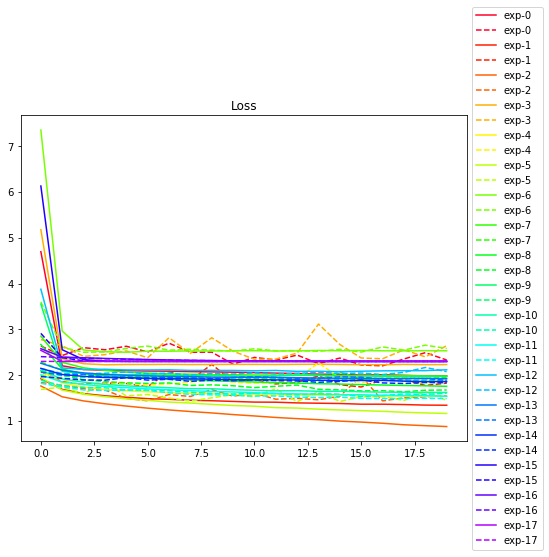

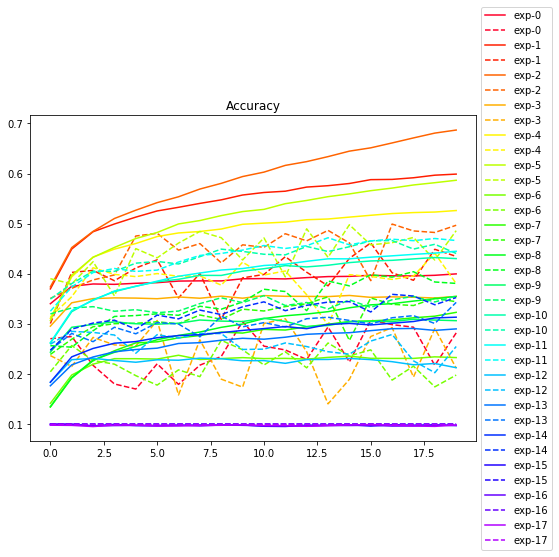

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = 20

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()